# Lab 11: Convolutional Neural Network (CNN)

## 1. Load the dataset

In [38]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
import pandas as pd


DATASET_PATH = '../data/Fish_Dataset/Fish_Dataset/'

In [39]:
def get_labels():
    folders = os.listdir(DATASET_PATH)
    labels = []
    for f in folders:
        if not('.m' in f) and not('.txt' in f):
            labels.append(f)
    labels = np.array(labels)
    return labels


def get_X_Y(labels, RGB=False):
    # Get the images for each label
    if RGB:
        img_shape = (128, 128) #resizing images to this shape ( after converting color image to gray image)
    else:
        img_shape = (128, 128)
    n_sample_per_class = 800 #Keep only this number of samples per class (expensive complexity issue)
    nb_img = n_sample_per_class*len(labels) #1000 images per class

    if RGB:
        X = np.zeros((nb_img, img_shape[0], img_shape[1], 3))
    else:
        X = np.zeros((nb_img, img_shape[0], img_shape[1])) # feature matrix
    Y = np.zeros(nb_img) #labels vector
    for i in range(len(labels)):
        folder = os.path.join(DATASET_PATH, labels[i], labels[i])
        images = os.listdir(folder)
        np.random.shuffle(images)
        for j in range(n_sample_per_class):
            img_path = os.path.join(folder, images[j])
            if RGB:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                X[i*n_sample_per_class+j, :, :, 0] = cv2.resize(src=img[:,:, 0], dsize=img_shape)/255
                X[i*n_sample_per_class+j, :, :, 1] = cv2.resize(src=img[:,:, 1], dsize=img_shape)/255
                X[i*n_sample_per_class+j, :, :, 2] = cv2.resize(src=img[:,:, 2], dsize=img_shape)/255
            else:
                img = cv2.imread(img_path, 0) #Load the gray image
                #Resizing
                img = cv2.resize(src=img, dsize=img_shape)
                #Normalization
                img = img/255
                #Add the image in the feature matrix and its labels to the label vector
                X[i*n_sample_per_class+j, :, :] = img
            Y[i*n_sample_per_class+j] = np.argwhere(labels==labels[i])[0]
    return X, Y


In [40]:
labels = get_labels()
X, Y = get_X_Y(labels)
print("Feature matrix shape: ", X.shape)
print("Feature matrix : \n", X)
print("Label vector : \n", Y)

Feature matrix shape:  (7200, 128, 128)
Feature matrix : 
 [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

## 2. Use a CNN

In [42]:
import tensorflow as tf
tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [43]:
cnn_layers = [[16, (5, 5)]] #filters, kernel_size for each CNN layer

In [44]:
def get_model(X, cnn_layers, fc_layers=None, channel=1):
    model = tf.keras.Sequential()
    # Input layer
    model.add(tf.keras.layers.Input(shape=(X.shape[1], X.shape[2], channel)))
    # Convolutional blocks
    for i in range(len(cnn_layers)):
        model.add(tf.keras.layers.Conv2D(filters=cnn_layers[i][0], kernel_size=cnn_layers[i][1], padding='same'))
        model.add(tf.keras.layers.MaxPool2D(strides=2))
        model.add(tf.keras.layers.Activation('relu'))
    # Flatten
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.3))
    # Fully-connected layers
    if fc_layers is not None:
        for i in range(len(fc_layers)):
            model.add(tf.keras.layers.Dense(units=fc_layers[i], activation='relu'))
            model.add(tf.keras.layers.Dropout(0.3))
    # Output layer
    model.add(tf.keras.layers.Dense(units=len(labels), activation='softmax'))
    return model

In [45]:
model = get_model(X, cnn_layers)
model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')

In [46]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 16)      416       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 activation_7 (Activation)   (None, 64, 64, 16)        0         
                                                                 
 flatten_7 (Flatten)         (None, 65536)             0         
                                                                 
 dropout_7 (Dropout)         (None, 65536)             0         
                                                                 
 dense_7 (Dense)             (None, 9)                 589833    
                                                      

In [47]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
  1/135 [..............................] - ETA: 38s - loss: 2.2191 - accuracy: 0.0625

2022-11-23 10:38:04.031963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


134/135 [============================>.] - ETA: 0s - loss: 1.4770 - accuracy: 0.5145

2022-11-23 10:38:06.645082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


135/135 [==============================] - 3s 21ms/step - loss: 1.4725 - accuracy: 0.5164 - val_loss: 0.8120 - val_accuracy: 0.7481
Epoch 2/30
135/135 [==============================] - 2s 17ms/step - loss: 0.5270 - accuracy: 0.8514 - val_loss: 0.4437 - val_accuracy: 0.8694
Epoch 3/30
135/135 [==============================] - 2s 17ms/step - loss: 0.2415 - accuracy: 0.9528 - val_loss: 0.4037 - val_accuracy: 0.8639
Epoch 4/30
135/135 [==============================] - 2s 17ms/step - loss: 0.1365 - accuracy: 0.9782 - val_loss: 0.2972 - val_accuracy: 0.9083
Epoch 5/30
135/135 [==============================] - 2s 18ms/step - loss: 0.0782 - accuracy: 0.9940 - val_loss: 0.2796 - val_accuracy: 0.9065
Epoch 6/30
135/135 [==============================] - 2s 18ms/step - loss: 0.0453 - accuracy: 0.9991 - val_loss: 0.2143 - val_accuracy: 0.9370
Epoch 7/30
135/135 [==============================] - 2s 18ms/step - loss: 0.0284 - accuracy: 1.0000 - val_loss: 0.2116 - val_accuracy: 0.9306
Epoch 8/30

In [48]:
def training_accuracy_plot(history):
    plt.figure()
    plt.plot(history.history['accuracy'], label='acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title('Accuracy evolution during training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [49]:
def training_loss_plot(history):
    plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss evolution during training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Plot the feature map

In [50]:
def get_filters(model):
    idx_conv = []
    f_conv = []
    for i in range(len(model.layers)):
        layer = model.layers[i]
        print('Layer {} : {}'.format(i, layer.name))
        if 'conv' in layer.name:
            idx_conv.append(i)
            filters, biases = model.layers[i].get_weights()
            f_min, f_max = filters.min(), filters.max()
            filters = (filters - f_min) / (f_max - f_min)

            n_filters, ix = 16, 1
            fig, ax = plt.subplots(4, 4, figsize=(10, 10))
            fig.suptitle('Convolutional layers {} : feature map '.format(i), fontweight='bold')
            idx = 0
            for i in range(4):
                for j in range(4):
                    # get the filter
                    f = filters[:, :, :, idx]
                    ax[i][j].set_xticks([])
                    ax[i][j].set_yticks([])
                    ax[i][j].set_title('Filter {}'.format(idx))
                    ax[i][j].imshow(f[:, :, 0], cmap='gray') #Only one channel -> 0
                    idx += 1
            # show the figure
            plt.tight_layout()
            plt.show()
    return idx_conv, f_conv

Layer 0 : conv2d_7


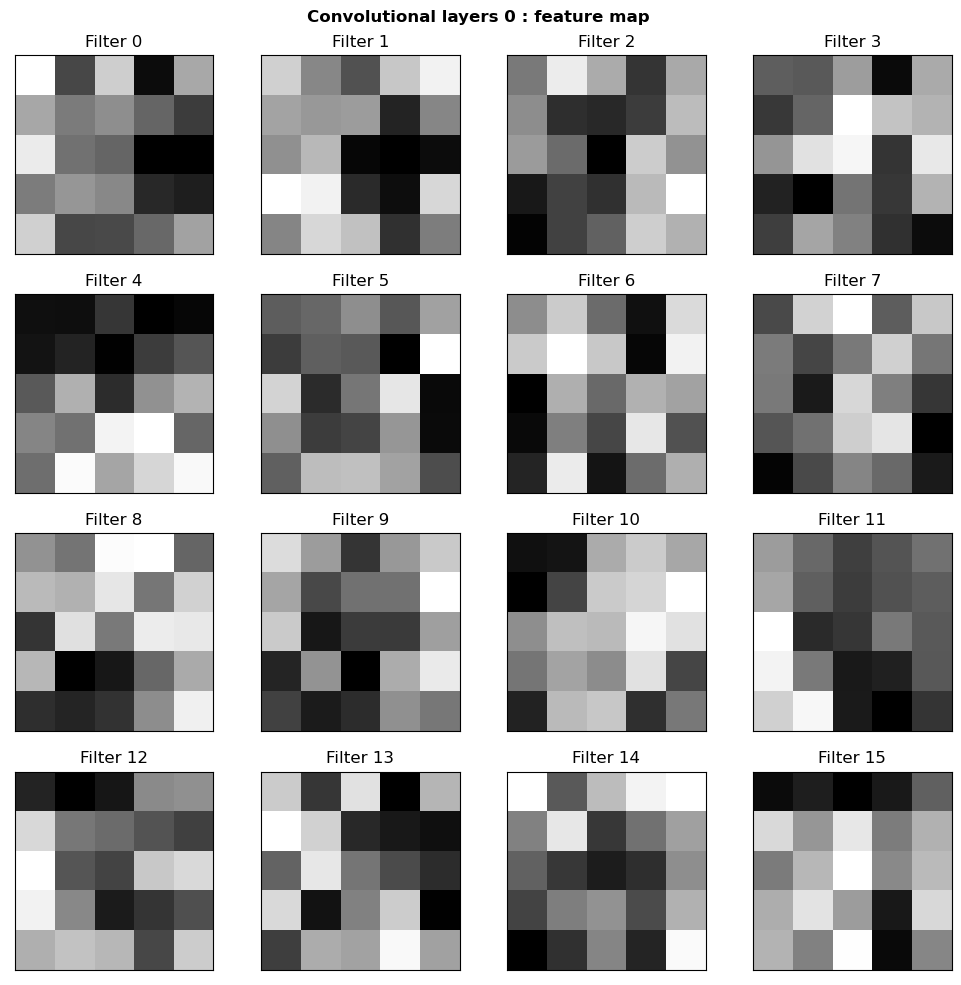

Layer 1 : max_pooling2d_7
Layer 2 : activation_7
Layer 3 : flatten_7
Layer 4 : dropout_7
Layer 5 : dense_7


In [51]:
idx_conv, f_conv = get_filters(model)

### Visualize the effect of the filter with a random image of the dataset

In [52]:
def plot_feature_map(model, X, idx_conv, i_conv, channel=0):
    # Get the output after the convolution (+pooling+activation)
    model_fm = tf.keras.Model(inputs=model.inputs, outputs=model.layers[idx_conv[i_conv]+2].output) #After pooling and activation function

    # Get a random image (32 images actually, but we'll plot only one) from the dataset
    idx_random = np.random.randint(0, X.shape[0], 32) #BATCH_SIZE = 32 to fit the input size
    img_batch = X[idx_random, :, :]
    img_batch_label =Y[idx_random]


    # Apply the convolution to the random image
    features_img = model_fm.predict(img_batch, verbose=0)

    # Plot the features map
    fig, ax = plt.subplots(4, 4, figsize=(15, 10))
    fig.suptitle('Convolutional layers {} : feature map effect on a {} sample '.format(idx_conv[0], labels[int(img_batch_label[0])]), fontweight='bold')
    idx = 0
    for i in range(4):
        for j in range(4):
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
            ax[i][j].set_title('Filter {}'.format(idx))
            ax[i][j].imshow(features_img[channel, :, :, idx], cmap='gray')  #Only one channel -> 0
            idx += 1
    # show the figure
    plt.tight_layout()
    plt.show()

2022-11-23 10:39:19.033718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


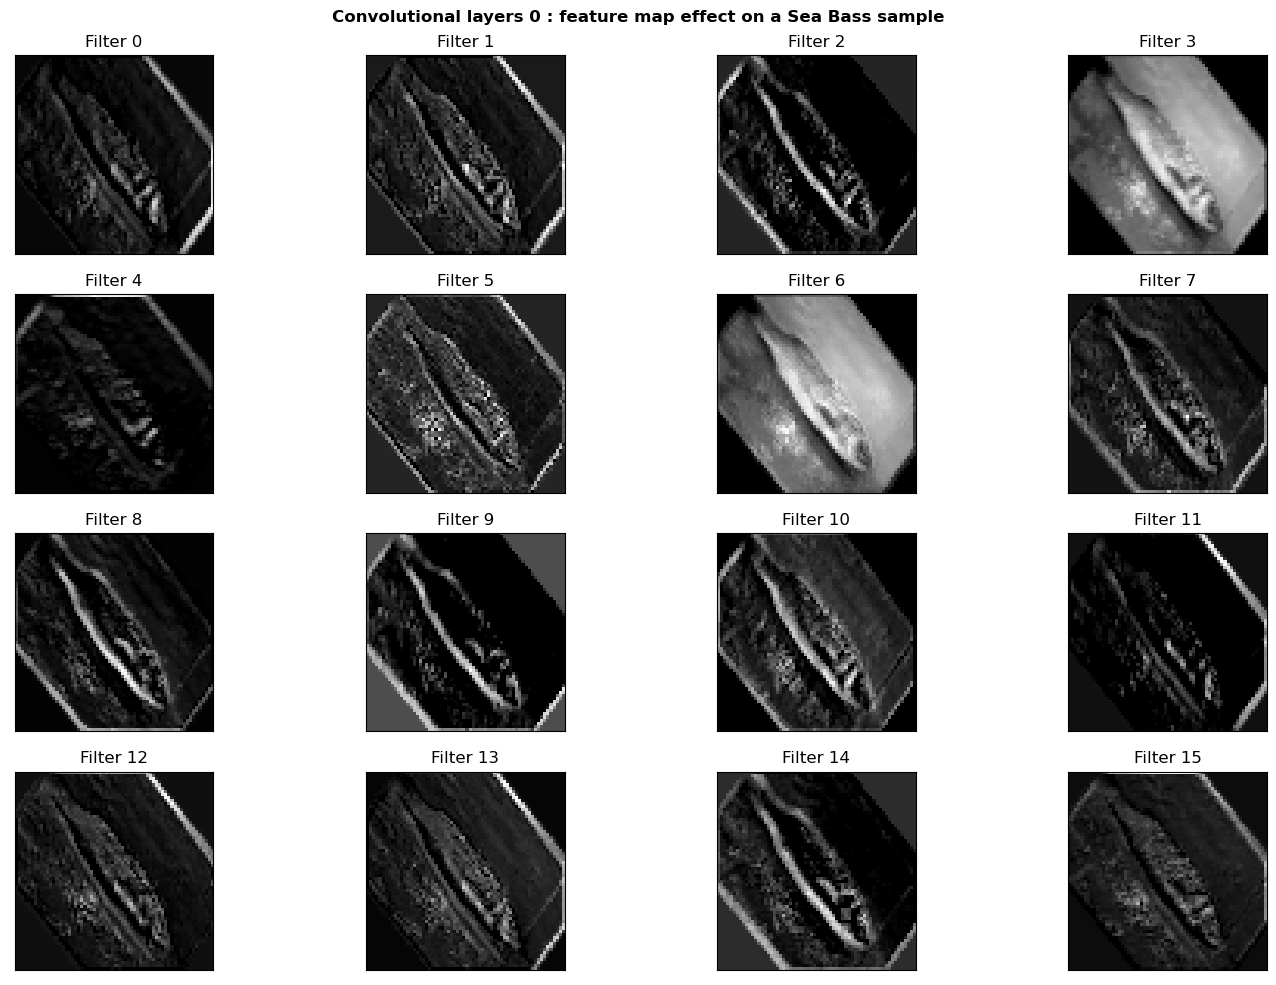

In [53]:
plot_feature_map(model, X, idx_conv, 0)

## 3. Try a CNN with the color images

In [54]:
X_RGB, Y_RGB = get_X_Y(labels, RGB=True)

In [55]:
X_train_RGB, X_test_RGB, y_train_RGB, y_test_RGB = train_test_split(X_RGB, Y_RGB, test_size=0.25, random_state=42)

In [56]:
model_RGB = get_model(X_RGB, cnn_layers, channel=3)

In [57]:
model.compile(optimizer="adam",
            loss='sparse_categorical_crossentropy',
             metrics='accuracy')

In [58]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 16)      416       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 activation_7 (Activation)   (None, 64, 64, 16)        0         
                                                                 
 flatten_7 (Flatten)         (None, 65536)             0         
                                                                 
 dropout_7 (Dropout)         (None, 65536)             0         
                                                                 
 dense_7 (Dense)             (None, 9)                 589833    
                                                      

In [59]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
  4/135 [..............................] - ETA: 2s - loss: 0.0309 - accuracy: 0.9922     

2022-11-23 10:40:00.054349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


132/135 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.9979

2022-11-23 10:40:02.534086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


135/135 [==============================] - 3s 20ms/step - loss: 0.0102 - accuracy: 0.9979 - val_loss: 0.1924 - val_accuracy: 0.9389
Epoch 2/30
135/135 [==============================] - 2s 18ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.1946 - val_accuracy: 0.9417
Epoch 3/30
135/135 [==============================] - 2s 17ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.2176 - val_accuracy: 0.9324
Epoch 4/30
135/135 [==============================] - 2s 17ms/step - loss: 0.0211 - accuracy: 0.9947 - val_loss: 0.2533 - val_accuracy: 0.9185
Epoch 5/30
135/135 [==============================] - 2s 18ms/step - loss: 0.0097 - accuracy: 0.9981 - val_loss: 0.2068 - val_accuracy: 0.9324
Epoch 6/30
135/135 [==============================] - 2s 18ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2015 - val_accuracy: 0.9380
Epoch 7/30
135/135 [==============================] - 2s 17ms/step - loss: 8.5872e-04 - accuracy: 1.0000 - val_loss: 0.1931 - val_accuracy: 0.9380
Epoch 

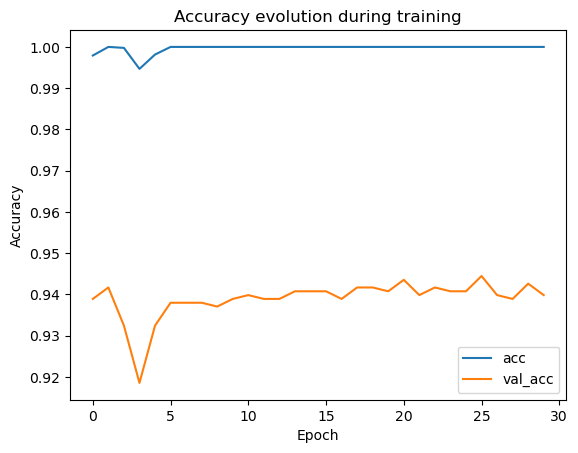

In [60]:
training_accuracy_plot(history)

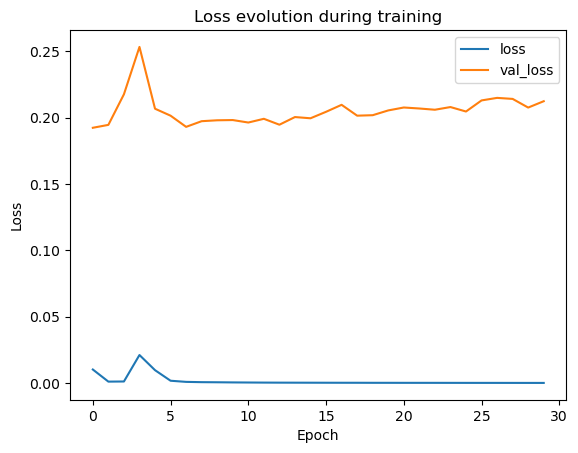

In [61]:
training_loss_plot(history)

Layer 0 : conv2d_8


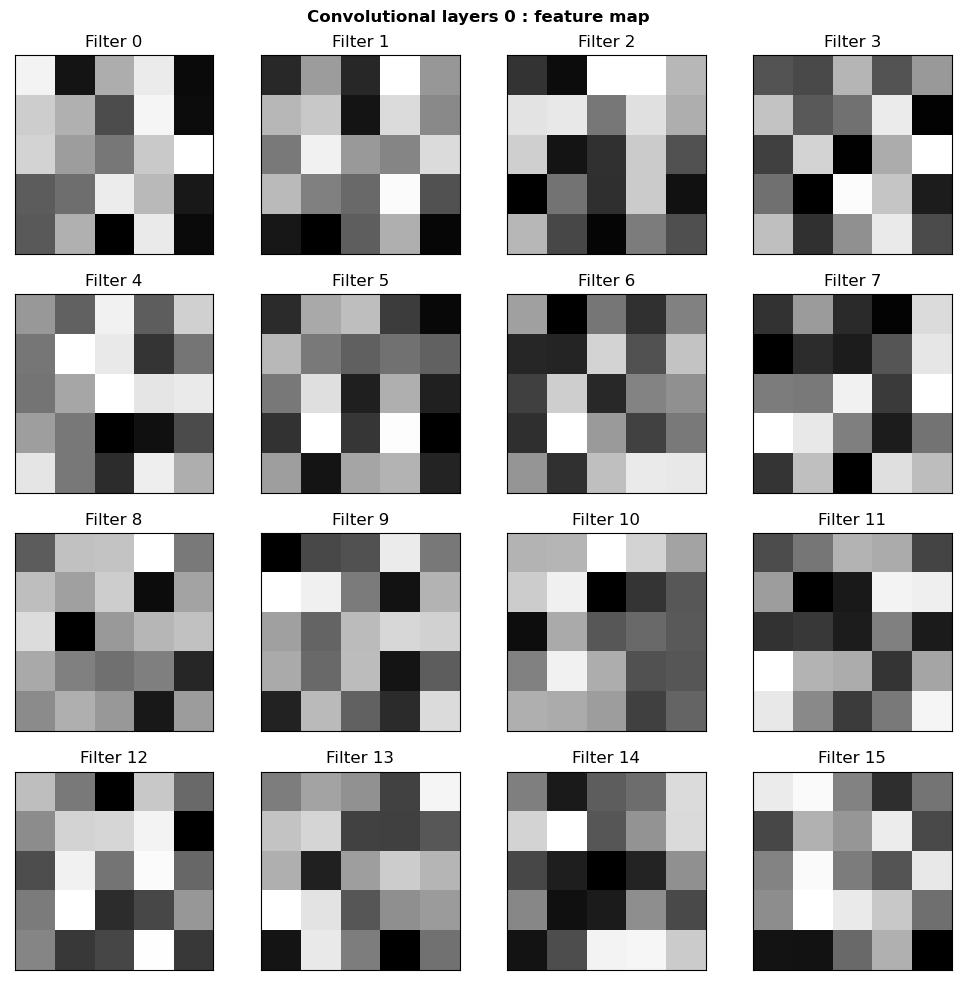

Layer 1 : max_pooling2d_8
Layer 2 : activation_8
Layer 3 : flatten_8
Layer 4 : dropout_8
Layer 5 : dense_8


In [62]:
idx_conv, f_conv = get_filters(model_RGB)

2022-11-23 10:41:12.529711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


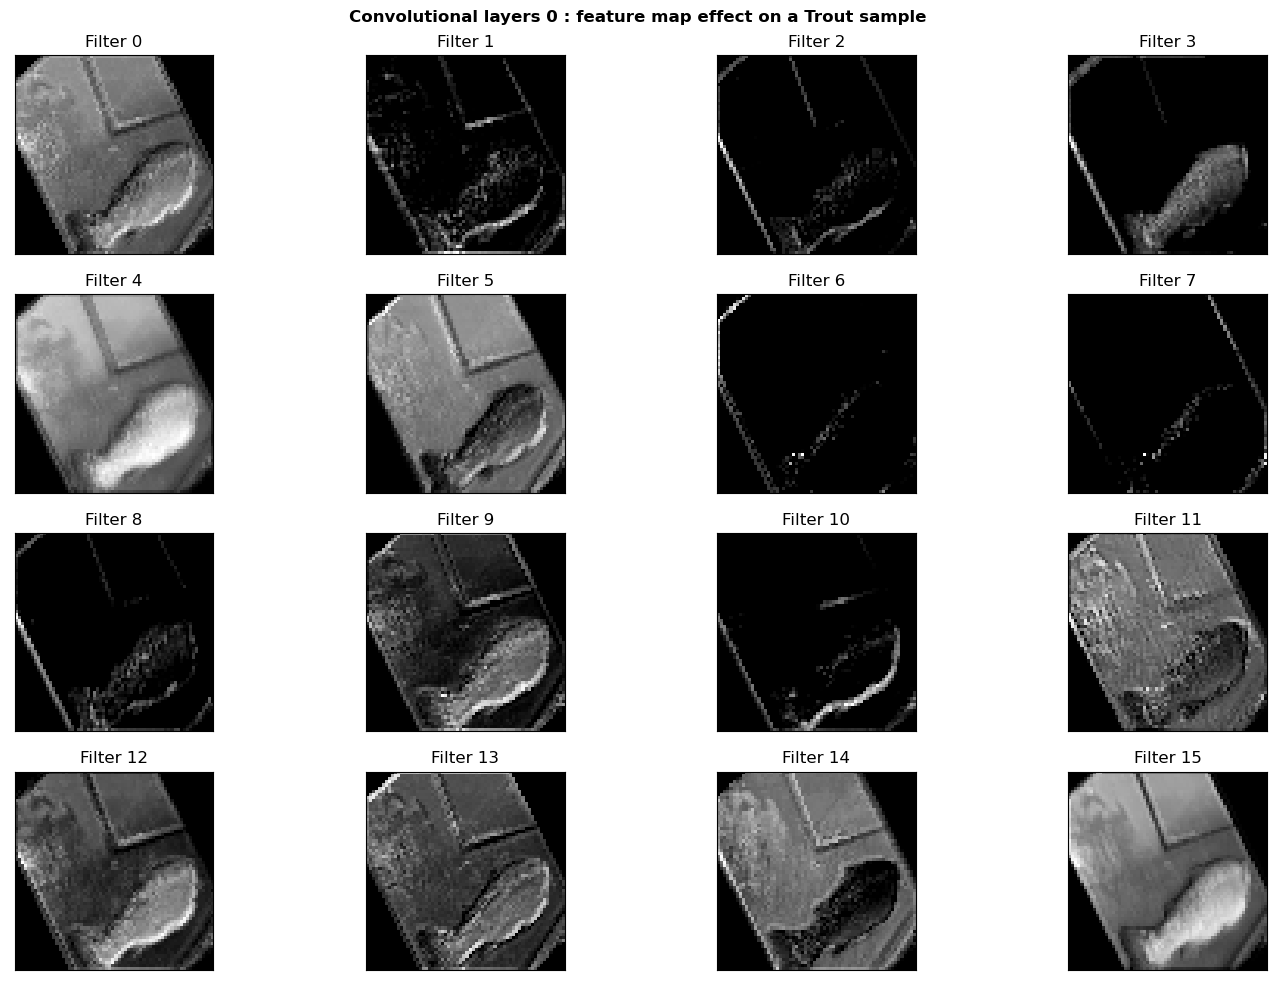

In [63]:
plot_feature_map(model_RGB, X_RGB, idx_conv, 0, channel=0)

2022-11-23 10:41:13.044042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


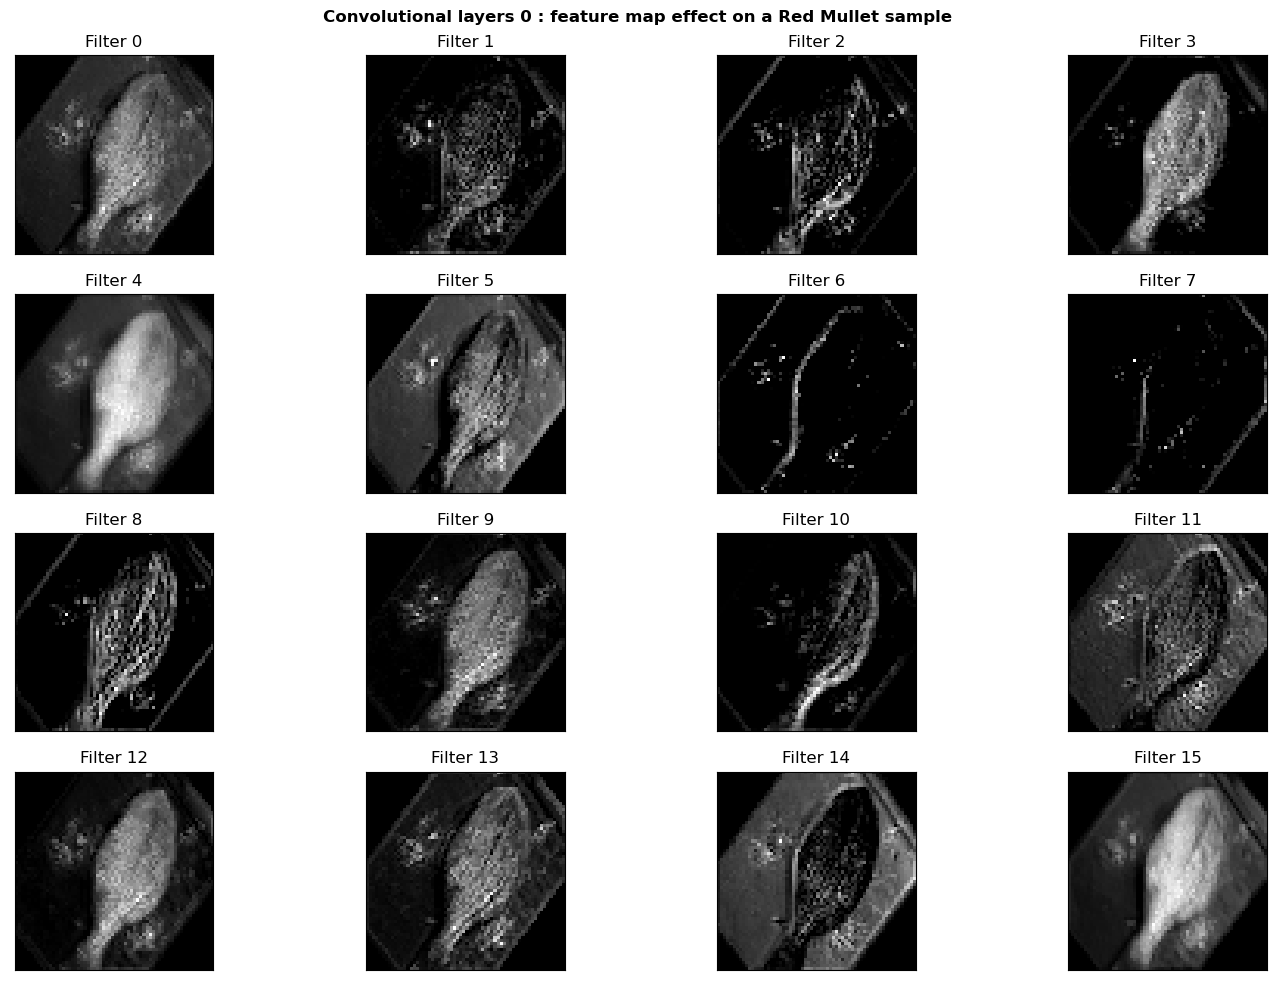

In [64]:
plot_feature_map(model_RGB, X_RGB, idx_conv, 0, channel=1)

2022-11-23 10:41:13.423635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


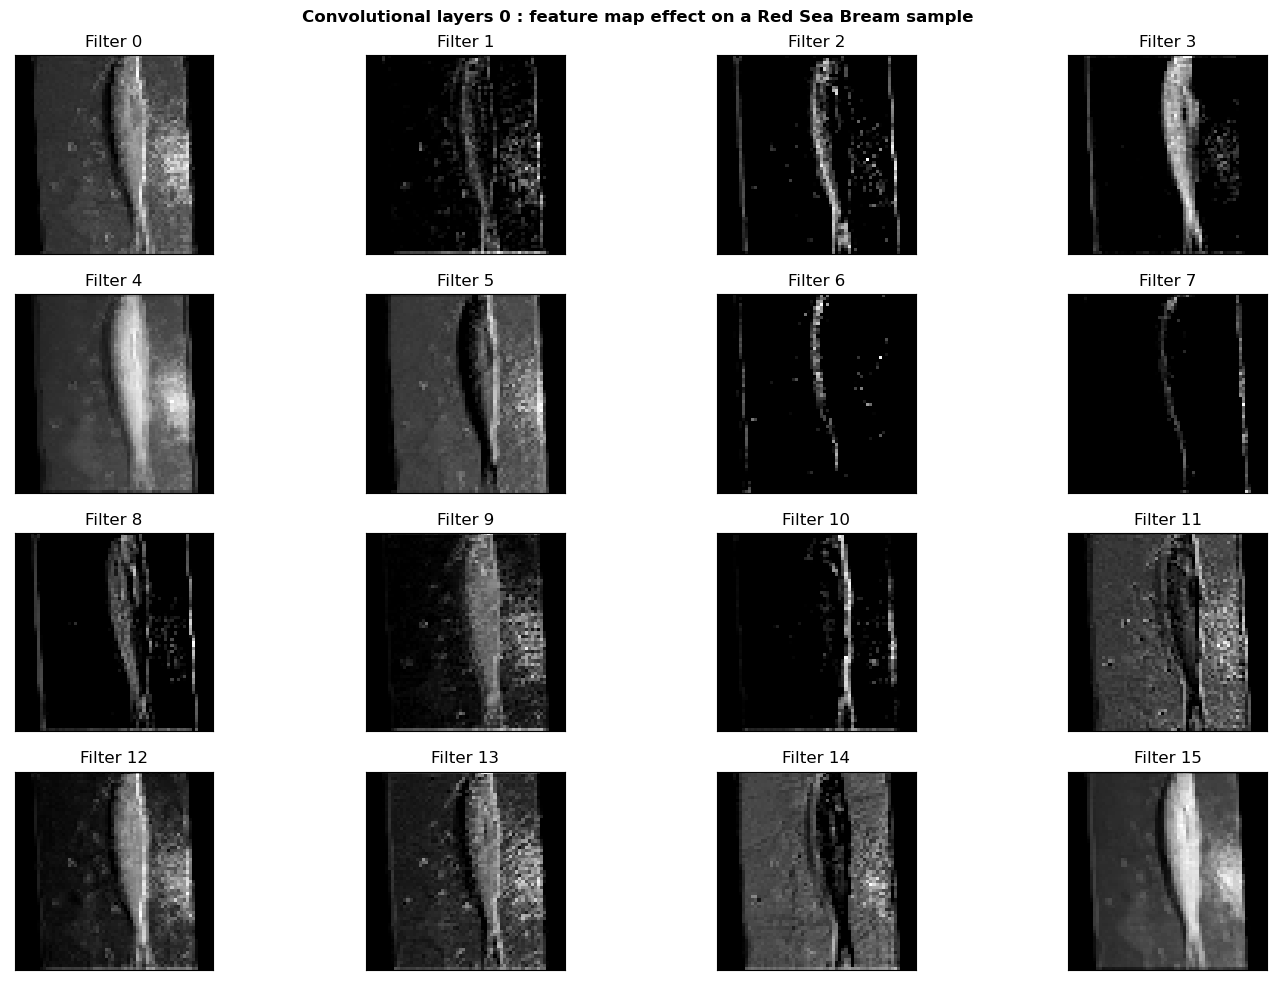

In [65]:
plot_feature_map(model_RGB, X_RGB, idx_conv, 0, channel=2)

## 4. Cross-validation

In [66]:
def cross_val_split(X, Y, k_fold=10, channel=1):
    """
    Split the dataset in k fold to prepare a cross-validation
    :param X_pca: feature matrix
    :param Y: label vector
    :param k_fold: number of fold
    :return:
    """
    idx = np.arange(0, X.shape[0])
    np.random.shuffle(idx)
    sample_per_fold = X.shape[0]//k_fold
    X_fold_test = []
    X_fold_train = []
    Y_fold_test = []
    Y_fold_train = []
    for i in range(k_fold):
        if i==k_fold-1:
            idx_fold_i = idx[i*sample_per_fold:len(idx)]
            idx_train_i = idx[0:i*sample_per_fold]
        elif i==0:
            idx_fold_i = idx[0:sample_per_fold]
            idx_train_i = idx[i*sample_per_fold:(i+1)*sample_per_fold]
        else:
            idx_fold_i = idx[i*sample_per_fold:(i+1)*sample_per_fold]
            idx_train_i = np.concatenate((idx[0:i*sample_per_fold], idx[(i+1)*sample_per_fold:len(idx)]), axis=None)
        if channel==3:
            X_fold_test.append(X[idx_fold_i, :, :])
            X_fold_train.append(X[idx_train_i, :, :])
        else:
            X_fold_test.append(X[idx_fold_i, :])
            X_fold_train.append(X[idx_train_i, :])
        Y_fold_test.append(Y[idx_fold_i])
        Y_fold_train.append(Y[idx_train_i])
    return X_fold_train, X_fold_test, Y_fold_train, Y_fold_test

In [67]:
def cross_val(X_pca, Y, cnn_layers, fc_layers=None, channel=1, k_fold=10, epochs=25, batch_size=16, l_rate=0.001):
    """
    Cross validation
    :param X_pca:
    :param Y:
    :param h_layers:
    :param k_fold:
    :param epochs:
    :param batch_size:
    :param l_rate:
    :return:
    """
    X_fold_train, X_fold_test, Y_fold_train, Y_fold_test = cross_val_split(X_pca, Y, k_fold=k_fold, channel=channel)
    y_pred_fold = []
    acc = []
    for i in range(k_fold):
        print('---'*10)
        print("k-fold {}".format(i))
        X_test_i = X_fold_test[i]
        Y_test_i = Y_fold_test[i]
        X_train_i = X_fold_train[i]
        Y_train_i = Y_fold_train[i]
        model = get_model(X_train_i, cnn_layers, fc_layers, channel)
        opt = tf.keras.optimizers.Adam(learning_rate=l_rate)
        model.compile(opt, loss='sparse_categorical_crossentropy', metrics='accuracy')
        model.fit(X_train_i, Y_train_i, epochs=epochs, batch_size=batch_size, verbose=1)

        pred_prob = model.predict(X_test_i)

        y_pred_i = np.argmax(pred_prob, axis=1)

        acc_i = len(np.where(y_pred_i==Y_test_i)[0])/len(Y_test_i)
        print('Test accuracy : {}'.format(acc_i))
        acc.append(acc_i)
        y_pred_fold.append(y_pred_i)
    return acc, y_pred_fold

In [68]:
def fine_tune_plot(ax, history_kfold, title, xlabel, ylabel):
    ax.boxplot([history_kfold[key] for key in history_kfold.keys()], showfliers=False)
    ax.set_title(title)
    ax.set_xticks(np.arange(1, len(history_kfold.keys()) + 1))
    ax.set_xticklabels([key for key in history_kfold.keys()])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)


In [69]:
cnn_layers = [[16, (5, 5)]]

In [70]:
acc_gray, _ = cross_val(X, Y, cnn_layers = cnn_layers, fc_layers=None, channel=1, epochs=15, k_fold=3, batch_size=32)

------------------------------
k-fold 0
Epoch 1/15
 4/75 [>.............................] - ETA: 1s - loss: 3.5481 - accuracy: 0.1484 

2022-11-23 10:41:15.647592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 2s 17ms/step - loss: 1.7837 - accuracy: 0.4133
Epoch 2/15
75/75 [==============================] - 1s 16ms/step - loss: 0.7739 - accuracy: 0.7933
Epoch 3/15
75/75 [==============================] - 1s 16ms/step - loss: 0.4378 - accuracy: 0.8963
Epoch 4/15
75/75 [==============================] - 1s 16ms/step - loss: 0.2704 - accuracy: 0.9483
Epoch 5/15
75/75 [==============================] - 1s 16ms/step - loss: 0.1706 - accuracy: 0.9775
Epoch 6/15
75/75 [==============================] - 1s 16ms/step - loss: 0.1049 - accuracy: 0.9938
Epoch 7/15
75/75 [==============================] - 1s 16ms/step - loss: 0.0737 - accuracy: 0.9971
Epoch 8/15
75/75 [==============================] - 1s 17ms/step - loss: 0.0465 - accuracy: 1.0000
Epoch 9/15
75/75 [==============================] - 1s 16ms/step - loss: 0.0348 - accuracy: 1.0000
Epoch 10/15
75/75 [==============================] - 1s 17ms/step - loss: 0.0268 - accuracy: 1.0000
Epoch 11/15
75/75 [=

2022-11-23 10:41:34.455546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 0s 4ms/step
Test accuracy : 1.0
------------------------------
k-fold 1
Epoch 1/15
  4/150 [..............................] - ETA: 2s - loss: 3.9565 - accuracy: 0.1797 

2022-11-23 10:41:35.311698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - 3s 16ms/step - loss: 1.4128 - accuracy: 0.5446
Epoch 2/15
150/150 [==============================] - 2s 16ms/step - loss: 0.5374 - accuracy: 0.8383
Epoch 3/15
150/150 [==============================] - 2s 16ms/step - loss: 0.2725 - accuracy: 0.9319
Epoch 4/15
150/150 [==============================] - 2s 16ms/step - loss: 0.1544 - accuracy: 0.9750
Epoch 5/15
150/150 [==============================] - 2s 16ms/step - loss: 0.0912 - accuracy: 0.9894
Epoch 6/15
150/150 [==============================] - 2s 16ms/step - loss: 0.0587 - accuracy: 0.9963
Epoch 7/15
150/150 [==============================] - 2s 16ms/step - loss: 0.0368 - accuracy: 0.9994
Epoch 8/15
150/150 [==============================] - 3s 17ms/step - loss: 0.0231 - accuracy: 0.9998
Epoch 9/15
150/150 [==============================] - 2s 17ms/step - loss: 0.0166 - accuracy: 0.9998
Epoch 10/15
150/150 [==============================] - 2s 16ms/step - loss: 0.0126 - accuracy: 1.0000


2022-11-23 10:42:11.735327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 0s 4ms/step
Test accuracy : 0.93375
------------------------------
k-fold 2
Epoch 1/15
  5/150 [>.............................] - ETA: 2s - loss: 2.5202 - accuracy: 0.1187 

2022-11-23 10:42:12.618368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - 3s 16ms/step - loss: 1.1921 - accuracy: 0.5956
Epoch 2/15
150/150 [==============================] - 2s 16ms/step - loss: 0.4089 - accuracy: 0.8819
Epoch 3/15
150/150 [==============================] - 2s 16ms/step - loss: 0.1988 - accuracy: 0.9592
Epoch 4/15
150/150 [==============================] - 2s 16ms/step - loss: 0.1074 - accuracy: 0.9831
Epoch 5/15
150/150 [==============================] - 2s 16ms/step - loss: 0.0619 - accuracy: 0.9938
Epoch 6/15
150/150 [==============================] - 2s 16ms/step - loss: 0.0370 - accuracy: 0.9990
Epoch 7/15
150/150 [==============================] - 2s 16ms/step - loss: 0.0226 - accuracy: 1.0000
Epoch 8/15
150/150 [==============================] - 2s 16ms/step - loss: 0.0163 - accuracy: 0.9996
Epoch 9/15
150/150 [==============================] - 2s 16ms/step - loss: 0.0127 - accuracy: 1.0000
Epoch 10/15
150/150 [==============================] - 2s 16ms/step - loss: 0.0087 - accuracy: 1.0000


2022-11-23 10:42:48.998631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 0s 4ms/step
Test accuracy : 0.9270833333333334


In [71]:
print('Accruracy : {} +- {}'.format(np.mean(acc_gray), np.std(acc_gray)))

Accruracy : 0.9536111111111111 +- 0.03291461550102396


In [72]:
#acc_RGB, _ = cross_val(X, Y_RGB, cnn_layers = cnn_layers, channel=3, epochs=15)
#history_color = {'gray': acc_gray, 'RGB':acc_RGB}

In [73]:
#f, ax = plt.subplots(1, figsize=(10, 10))
#fine_tune_plot(ax,history_color, 'Comparison of the performances of the CNN model related to the colors space of the images', 'Color space', 'Accuracy')

In [74]:
cnn_layers_test = [ [[8, (5, 5)]] , [[16, (5, 5)]]]

In [75]:
history_conv_layer_1 = {}
for i in range(len(cnn_layers_test)):
    print('CROSS VALIDATION with {} filters'.format(cnn_layers_test[i][0]))
    acc, y_pred = cross_val(X, Y, cnn_layers=cnn_layers_test[i], fc_layers=None, channel=1, epochs=10, batch_size=32)
    history_conv_layer_1[cnn_layers_test[i][0][0]] = acc


CROSS VALIDATION with [8, (5, 5)] filters
------------------------------
k-fold 0
Epoch 1/10


2022-11-23 10:42:52.267885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 17ms/step - loss: 2.2836 - accuracy: 0.2014
Epoch 2/10
23/23 [==============================] - 0s 16ms/step - loss: 1.5722 - accuracy: 0.5083
Epoch 3/10
23/23 [==============================] - 0s 13ms/step - loss: 1.2275 - accuracy: 0.5958
Epoch 4/10
23/23 [==============================] - 0s 14ms/step - loss: 0.9764 - accuracy: 0.7417
Epoch 5/10
23/23 [==============================] - 0s 14ms/step - loss: 0.7713 - accuracy: 0.8028
Epoch 6/10
23/23 [==============================] - 0s 20ms/step - loss: 0.6169 - accuracy: 0.8556
Epoch 7/10
23/23 [==============================] - 0s 13ms/step - loss: 0.5271 - accuracy: 0.8986
Epoch 8/10
23/23 [==============================] - 0s 13ms/step - loss: 0.4241 - accuracy: 0.9208
Epoch 9/10
23/23 [==============================] - 0s 13ms/step - loss: 0.3405 - accuracy: 0.9542
Epoch 10/10
23/23 [==============================] - 0s 4ms/step


2022-11-23 10:42:56.365777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test accuracy : 0.975
------------------------------
k-fold 1
Epoch 1/10
  4/203 [..............................] - ETA: 3s - loss: 2.4968 - accuracy: 0.1094 

2022-11-23 10:42:57.800833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 3s 13ms/step - loss: 1.2131 - accuracy: 0.5985
Epoch 2/10
203/203 [==============================] - 3s 13ms/step - loss: 0.4393 - accuracy: 0.8850
Epoch 3/10
203/203 [==============================] - 3s 13ms/step - loss: 0.2247 - accuracy: 0.9525
Epoch 4/10
203/203 [==============================] - 3s 13ms/step - loss: 0.1370 - accuracy: 0.9765
Epoch 5/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0764 - accuracy: 0.9935
Epoch 6/10
203/203 [==============================] - 3s 14ms/step - loss: 0.0475 - accuracy: 0.9975
Epoch 7/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0329 - accuracy: 0.9992
Epoch 8/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0233 - accuracy: 0.9995
Epoch 9/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0177 - accuracy: 0.9997
Epoch 10/10
23/23 [==============================] - 0s 5ms/step


2022-11-23 10:43:25.261517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test accuracy : 0.9375
------------------------------
k-fold 2
Epoch 1/10
  5/203 [..............................] - ETA: 2s - loss: 2.8188 - accuracy: 0.1437 

2022-11-23 10:43:26.517181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 3s 14ms/step - loss: 1.2317 - accuracy: 0.5921
Epoch 2/10
203/203 [==============================] - 3s 14ms/step - loss: 0.4459 - accuracy: 0.8753
Epoch 3/10
203/203 [==============================] - 3s 13ms/step - loss: 0.2388 - accuracy: 0.9452
Epoch 4/10
203/203 [==============================] - 3s 14ms/step - loss: 0.1438 - accuracy: 0.9744
Epoch 5/10
203/203 [==============================] - 3s 14ms/step - loss: 0.0884 - accuracy: 0.9884
Epoch 6/10
203/203 [==============================] - 3s 14ms/step - loss: 0.0523 - accuracy: 0.9961
Epoch 7/10
203/203 [==============================] - 3s 14ms/step - loss: 0.0359 - accuracy: 0.9981
Epoch 8/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0277 - accuracy: 0.9989
Epoch 9/10
203/203 [==============================] - 3s 15ms/step - loss: 0.0181 - accuracy: 0.9998
Epoch 10/10
23/23 [==============================] - 0s 4ms/step


2022-11-23 10:43:54.934313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test accuracy : 0.9375
------------------------------
k-fold 3
Epoch 1/10
  4/203 [..............................] - ETA: 3s - loss: 2.2319 - accuracy: 0.1641 

2022-11-23 10:43:56.743705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 3s 15ms/step - loss: 1.0919 - accuracy: 0.6383
Epoch 2/10
203/203 [==============================] - 3s 15ms/step - loss: 0.4044 - accuracy: 0.8906
Epoch 3/10
203/203 [==============================] - 3s 14ms/step - loss: 0.2128 - accuracy: 0.9545
Epoch 4/10
203/203 [==============================] - 3s 13ms/step - loss: 0.1261 - accuracy: 0.9801
Epoch 5/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0812 - accuracy: 0.9894
Epoch 6/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0540 - accuracy: 0.9944
Epoch 7/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0351 - accuracy: 0.9986
Epoch 8/10
203/203 [==============================] - 3s 14ms/step - loss: 0.0279 - accuracy: 0.9988
Epoch 9/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0196 - accuracy: 0.9992
Epoch 10/10
23/23 [==============================] - 0s 7ms/step


2022-11-23 10:44:25.177830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test accuracy : 0.9430555555555555
------------------------------
k-fold 4
Epoch 1/10
  5/203 [..............................] - ETA: 2s - loss: 3.3661 - accuracy: 0.1313 

2022-11-23 10:44:27.479149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 3s 13ms/step - loss: 1.4924 - accuracy: 0.5062
Epoch 2/10
203/203 [==============================] - 3s 13ms/step - loss: 0.6869 - accuracy: 0.7958
Epoch 3/10
203/203 [==============================] - 3s 14ms/step - loss: 0.4034 - accuracy: 0.8960
Epoch 4/10
203/203 [==============================] - 3s 14ms/step - loss: 0.2474 - accuracy: 0.9446
Epoch 5/10
203/203 [==============================] - 3s 13ms/step - loss: 0.1576 - accuracy: 0.9724
Epoch 6/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0986 - accuracy: 0.9886
Epoch 7/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0694 - accuracy: 0.9934
Epoch 8/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0473 - accuracy: 0.9969
Epoch 9/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0353 - accuracy: 0.9988
Epoch 10/10
23/23 [==============================] - 0s 5ms/step


2022-11-23 10:44:55.049139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test accuracy : 0.9458333333333333
------------------------------
k-fold 5
Epoch 1/10
  5/203 [..............................] - ETA: 2s - loss: 3.2471 - accuracy: 0.1250 

2022-11-23 10:44:56.864801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 3s 14ms/step - loss: 1.3430 - accuracy: 0.5681
Epoch 2/10
203/203 [==============================] - 3s 15ms/step - loss: 0.5156 - accuracy: 0.8603
Epoch 3/10
203/203 [==============================] - 3s 14ms/step - loss: 0.2845 - accuracy: 0.9369
Epoch 4/10
203/203 [==============================] - 3s 14ms/step - loss: 0.1773 - accuracy: 0.9681
Epoch 5/10
203/203 [==============================] - 3s 14ms/step - loss: 0.1119 - accuracy: 0.9832
Epoch 6/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0709 - accuracy: 0.9938
Epoch 7/10
203/203 [==============================] - 3s 14ms/step - loss: 0.0515 - accuracy: 0.9961
Epoch 8/10
203/203 [==============================] - 3s 14ms/step - loss: 0.0339 - accuracy: 0.9988
Epoch 9/10
203/203 [==============================] - 3s 15ms/step - loss: 0.0224 - accuracy: 0.9997
Epoch 10/10
23/23 [==============================] - 0s 5ms/step


2022-11-23 10:45:25.734862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test accuracy : 0.9541666666666667
------------------------------
k-fold 6
Epoch 1/10
  4/203 [..............................] - ETA: 3s - loss: 3.5579 - accuracy: 0.1094 

2022-11-23 10:45:27.430046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 3s 14ms/step - loss: 1.3985 - accuracy: 0.5417
Epoch 2/10
203/203 [==============================] - 3s 14ms/step - loss: 0.5921 - accuracy: 0.8293
Epoch 3/10
203/203 [==============================] - 3s 14ms/step - loss: 0.3475 - accuracy: 0.9151
Epoch 4/10
203/203 [==============================] - 3s 14ms/step - loss: 0.2204 - accuracy: 0.9519
Epoch 5/10
203/203 [==============================] - 3s 13ms/step - loss: 0.1447 - accuracy: 0.9773
Epoch 6/10
203/203 [==============================] - 3s 14ms/step - loss: 0.0988 - accuracy: 0.9904
Epoch 7/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0696 - accuracy: 0.9931
Epoch 8/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0489 - accuracy: 0.9983
Epoch 9/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0324 - accuracy: 0.9989
Epoch 10/10
23/23 [==============================] - 0s 5ms/step


2022-11-23 10:45:55.387064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test accuracy : 0.9402777777777778
------------------------------
k-fold 7
Epoch 1/10
  5/203 [..............................] - ETA: 3s - loss: 2.4495 - accuracy: 0.1313 

2022-11-23 10:45:57.134774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 3s 14ms/step - loss: 1.1783 - accuracy: 0.6060
Epoch 2/10
203/203 [==============================] - 3s 13ms/step - loss: 0.4636 - accuracy: 0.8727
Epoch 3/10
203/203 [==============================] - 3s 14ms/step - loss: 0.2587 - accuracy: 0.9383
Epoch 4/10
203/203 [==============================] - 3s 13ms/step - loss: 0.1573 - accuracy: 0.9722
Epoch 5/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0994 - accuracy: 0.9855
Epoch 6/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0620 - accuracy: 0.9946
Epoch 7/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0416 - accuracy: 0.9975
Epoch 8/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0336 - accuracy: 0.9981
Epoch 9/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0227 - accuracy: 0.9997
Epoch 10/10
23/23 [==============================] - 0s 5ms/step


2022-11-23 10:46:24.286253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test accuracy : 0.9361111111111111
------------------------------
k-fold 8
Epoch 1/10
  5/203 [..............................] - ETA: 2s - loss: 2.1837 - accuracy: 0.1813 

2022-11-23 10:46:26.064821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 3s 13ms/step - loss: 1.1527 - accuracy: 0.6102
Epoch 2/10
203/203 [==============================] - 3s 13ms/step - loss: 0.4380 - accuracy: 0.8849
Epoch 3/10
203/203 [==============================] - 3s 13ms/step - loss: 0.2271 - accuracy: 0.9497
Epoch 4/10
203/203 [==============================] - 3s 13ms/step - loss: 0.1277 - accuracy: 0.9792
Epoch 5/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0730 - accuracy: 0.9923
Epoch 6/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0495 - accuracy: 0.9968
Epoch 7/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0305 - accuracy: 0.9994
Epoch 8/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0213 - accuracy: 1.0000
Epoch 9/10
203/203 [==============================] - 3s 13ms/step - loss: 0.0149 - accuracy: 1.0000
Epoch 10/10
23/23 [==============================] - 0s 4ms/step


2022-11-23 10:46:52.922724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test accuracy : 0.9319444444444445
------------------------------
k-fold 9
Epoch 1/10
  5/203 [..............................] - ETA: 3s - loss: 2.8034 - accuracy: 0.0813 

2022-11-23 10:46:54.764411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 3s 13ms/step - loss: 1.3664 - accuracy: 0.5488
Epoch 2/10
203/203 [==============================] - 3s 13ms/step - loss: 0.5853 - accuracy: 0.8336
Epoch 3/10
203/203 [==============================] - 3s 13ms/step - loss: 0.3159 - accuracy: 0.9270
Epoch 4/10
203/203 [==============================] - 3s 13ms/step - loss: 0.1901 - accuracy: 0.9664
Epoch 5/10
203/203 [==============================] - 3s 13ms/step - loss: 0.1165 - accuracy: 0.9856
Epoch 6/10
203/203 [==============================] - 3s 14ms/step - loss: 0.0778 - accuracy: 0.9918
Epoch 7/10
203/203 [==============================] - 3s 14ms/step - loss: 0.0486 - accuracy: 0.9989
Epoch 8/10
203/203 [==============================] - 3s 14ms/step - loss: 0.0361 - accuracy: 0.9991
Epoch 9/10
203/203 [==============================] - 3s 15ms/step - loss: 0.0270 - accuracy: 0.9997
Epoch 10/10
23/23 [==============================] - 0s 4ms/step


2022-11-23 10:47:22.484508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test accuracy : 0.9680555555555556
CROSS VALIDATION with [16, (5, 5)] filters
------------------------------
k-fold 0
Epoch 1/10


2022-11-23 10:47:26.442285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 19ms/step - loss: 3.2550 - accuracy: 0.1833
Epoch 2/10
23/23 [==============================] - 0s 16ms/step - loss: 1.7766 - accuracy: 0.4306
Epoch 3/10
23/23 [==============================] - 0s 16ms/step - loss: 1.3555 - accuracy: 0.5833
Epoch 4/10
23/23 [==============================] - 0s 16ms/step - loss: 1.0329 - accuracy: 0.7042
Epoch 5/10
23/23 [==============================] - 0s 17ms/step - loss: 0.7930 - accuracy: 0.7917
Epoch 6/10
23/23 [==============================] - 0s 17ms/step - loss: 0.6080 - accuracy: 0.8681
Epoch 7/10
23/23 [==============================] - 0s 16ms/step - loss: 0.4209 - accuracy: 0.9333
Epoch 8/10
23/23 [==============================] - 0s 16ms/step - loss: 0.3236 - accuracy: 0.9722
Epoch 9/10
23/23 [==============================] - 0s 17ms/step - loss: 0.2359 - accuracy: 0.9792
Epoch 10/10
23/23 [==============================] - 0s 5ms/step


2022-11-23 10:47:30.616206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test accuracy : 0.9986111111111111
------------------------------
k-fold 1
Epoch 1/10
  4/203 [..............................] - ETA: 3s - loss: 2.4788 - accuracy: 0.1250 

2022-11-23 10:47:31.620377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 4s 17ms/step - loss: 1.0557 - accuracy: 0.6483
Epoch 2/10
203/203 [==============================] - 4s 18ms/step - loss: 0.3314 - accuracy: 0.9160
Epoch 3/10
203/203 [==============================] - 3s 17ms/step - loss: 0.1616 - accuracy: 0.9667
Epoch 4/10
203/203 [==============================] - 3s 17ms/step - loss: 0.0840 - accuracy: 0.9863
Epoch 5/10
203/203 [==============================] - 3s 17ms/step - loss: 0.0446 - accuracy: 0.9960
Epoch 6/10
203/203 [==============================] - 4s 18ms/step - loss: 0.0268 - accuracy: 0.9994
Epoch 7/10
203/203 [==============================] - 4s 18ms/step - loss: 0.0172 - accuracy: 0.9998
Epoch 8/10
203/203 [==============================] - 3s 17ms/step - loss: 0.0126 - accuracy: 0.9998
Epoch 9/10
203/203 [==============================] - 3s 17ms/step - loss: 0.0082 - accuracy: 0.9998
Epoch 10/10
23/23 [==============================] - 0s 5ms/step


2022-11-23 10:48:06.469097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test accuracy : 0.9472222222222222
------------------------------
k-fold 2
Epoch 1/10
  4/203 [..............................] - ETA: 3s - loss: 3.1391 - accuracy: 0.0938 

2022-11-23 10:48:07.625029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 4s 17ms/step - loss: 1.1316 - accuracy: 0.6221
Epoch 2/10
203/203 [==============================] - 3s 17ms/step - loss: 0.3244 - accuracy: 0.9119
Epoch 3/10
203/203 [==============================] - 3s 17ms/step - loss: 0.1389 - accuracy: 0.9719
Epoch 4/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0729 - accuracy: 0.9900
Epoch 5/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0388 - accuracy: 0.9972
Epoch 6/10
203/203 [==============================] - 3s 17ms/step - loss: 0.0249 - accuracy: 0.9983
Epoch 7/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0140 - accuracy: 0.9997
Epoch 8/10
203/203 [==============================] - 4s 18ms/step - loss: 0.0102 - accuracy: 0.9997
Epoch 9/10
203/203 [==============================] - 3s 17ms/step - loss: 0.0089 - accuracy: 1.0000
Epoch 10/10
23/23 [==============================] - 0s 5ms/step


2022-11-23 10:48:42.037260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test accuracy : 0.9486111111111111
------------------------------
k-fold 3
Epoch 1/10
  4/203 [..............................] - ETA: 3s - loss: 3.9738 - accuracy: 0.0781 

2022-11-23 10:48:43.339916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 4s 17ms/step - loss: 1.2251 - accuracy: 0.6068
Epoch 2/10
203/203 [==============================] - 3s 17ms/step - loss: 0.4209 - accuracy: 0.8852
Epoch 3/10
203/203 [==============================] - 3s 16ms/step - loss: 0.2077 - accuracy: 0.9559
Epoch 4/10
203/203 [==============================] - 3s 17ms/step - loss: 0.1130 - accuracy: 0.9823
Epoch 5/10
203/203 [==============================] - 4s 18ms/step - loss: 0.0661 - accuracy: 0.9926
Epoch 6/10
203/203 [==============================] - 3s 17ms/step - loss: 0.0398 - accuracy: 0.9974
Epoch 7/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0253 - accuracy: 0.9992
Epoch 8/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0164 - accuracy: 0.9998
Epoch 9/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0123 - accuracy: 0.9995
Epoch 10/10
23/23 [==============================] - 0s 7ms/step


2022-11-23 10:49:17.611715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test accuracy : 0.9541666666666667
------------------------------
k-fold 4
Epoch 1/10
  1/203 [..............................] - ETA: 1:01 - loss: 2.2228 - accuracy: 0.0938

2022-11-23 10:49:19.507997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 5s 23ms/step - loss: 1.0451 - accuracy: 0.6616
Epoch 2/10
203/203 [==============================] - 4s 22ms/step - loss: 0.3228 - accuracy: 0.9177
Epoch 3/10
203/203 [==============================] - 5s 23ms/step - loss: 0.1375 - accuracy: 0.9753
Epoch 4/10
203/203 [==============================] - 5s 23ms/step - loss: 0.0663 - accuracy: 0.9934
Epoch 5/10
203/203 [==============================] - 5s 22ms/step - loss: 0.0364 - accuracy: 0.9978
Epoch 6/10
203/203 [==============================] - 4s 22ms/step - loss: 0.0226 - accuracy: 0.9997
Epoch 7/10
203/203 [==============================] - 5s 22ms/step - loss: 0.0150 - accuracy: 0.9995
Epoch 8/10
203/203 [==============================] - 5s 22ms/step - loss: 0.0092 - accuracy: 1.0000
Epoch 9/10
203/203 [==============================] - 4s 22ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 10/10
19/23 [=======================>......] - ETA: 0s

2022-11-23 10:50:04.842304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 9ms/step
Test accuracy : 0.9291666666666667
------------------------------
k-fold 5
Epoch 1/10
  4/203 [..............................] - ETA: 4s - loss: 2.5996 - accuracy: 0.1172 

2022-11-23 10:50:06.752233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 5s 22ms/step - loss: 1.1089 - accuracy: 0.6293
Epoch 2/10
203/203 [==============================] - 4s 22ms/step - loss: 0.3309 - accuracy: 0.9144
Epoch 3/10
203/203 [==============================] - 4s 22ms/step - loss: 0.1515 - accuracy: 0.9673
Epoch 4/10
203/203 [==============================] - 4s 22ms/step - loss: 0.0748 - accuracy: 0.9912
Epoch 5/10
203/203 [==============================] - 4s 22ms/step - loss: 0.0421 - accuracy: 0.9975
Epoch 6/10
203/203 [==============================] - 4s 22ms/step - loss: 0.0237 - accuracy: 0.9992
Epoch 7/10
203/203 [==============================] - 4s 22ms/step - loss: 0.0141 - accuracy: 1.0000
Epoch 8/10
203/203 [==============================] - 4s 22ms/step - loss: 0.0101 - accuracy: 1.0000
Epoch 9/10
203/203 [==============================] - 4s 21ms/step - loss: 0.0070 - accuracy: 0.9998
Epoch 10/10
20/23 [=========================>....] - ETA: 0s

2022-11-23 10:50:51.267549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 9ms/step
Test accuracy : 0.9597222222222223
------------------------------
k-fold 6
Epoch 1/10
  3/203 [..............................] - ETA: 5s - loss: 2.6577 - accuracy: 0.1562 

2022-11-23 10:50:53.148218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 5s 22ms/step - loss: 1.0662 - accuracy: 0.6522
Epoch 2/10
203/203 [==============================] - 4s 22ms/step - loss: 0.3275 - accuracy: 0.9086
Epoch 3/10
203/203 [==============================] - 4s 22ms/step - loss: 0.1517 - accuracy: 0.9674
Epoch 4/10
203/203 [==============================] - 4s 22ms/step - loss: 0.0815 - accuracy: 0.9880
Epoch 5/10
203/203 [==============================] - 4s 22ms/step - loss: 0.0425 - accuracy: 0.9966
Epoch 6/10
203/203 [==============================] - 4s 22ms/step - loss: 0.0246 - accuracy: 0.9992
Epoch 7/10
203/203 [==============================] - 4s 22ms/step - loss: 0.0152 - accuracy: 0.9997
Epoch 8/10
203/203 [==============================] - 4s 22ms/step - loss: 0.0099 - accuracy: 1.0000
Epoch 9/10
203/203 [==============================] - 4s 22ms/step - loss: 0.0074 - accuracy: 0.9998
Epoch 10/10
17/23 [=====================>........] - ETA: 0s

2022-11-23 10:51:38.375847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 11ms/step
Test accuracy : 0.9541666666666667
------------------------------
k-fold 7
Epoch 1/10
  4/203 [..............................] - ETA: 3s - loss: 4.0759 - accuracy: 0.1406   

2022-11-23 10:51:43.399388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 7s 17ms/step - loss: 1.2838 - accuracy: 0.5938
Epoch 2/10
203/203 [==============================] - 3s 16ms/step - loss: 0.3840 - accuracy: 0.8981
Epoch 3/10
203/203 [==============================] - 3s 16ms/step - loss: 0.1851 - accuracy: 0.9590
Epoch 4/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0952 - accuracy: 0.9852
Epoch 5/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0538 - accuracy: 0.9951
Epoch 6/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0283 - accuracy: 0.9998
Epoch 7/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0188 - accuracy: 0.9997
Epoch 8/10
203/203 [==============================] - 3s 17ms/step - loss: 0.0157 - accuracy: 0.9991
Epoch 9/10
203/203 [==============================] - 3s 17ms/step - loss: 0.0100 - accuracy: 1.0000
Epoch 10/10
23/23 [==============================] - 0s 5ms/step


2022-11-23 10:52:17.217478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test accuracy : 0.9361111111111111
------------------------------
k-fold 8
Epoch 1/10
  1/203 [..............................] - ETA: 59s - loss: 2.2400 - accuracy: 0.0625

2022-11-23 10:52:19.109279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 4s 17ms/step - loss: 1.0634 - accuracy: 0.6503
Epoch 2/10
203/203 [==============================] - 3s 16ms/step - loss: 0.3417 - accuracy: 0.9076
Epoch 3/10
203/203 [==============================] - 3s 16ms/step - loss: 0.1575 - accuracy: 0.9667
Epoch 4/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0818 - accuracy: 0.9909
Epoch 5/10
203/203 [==============================] - 3s 17ms/step - loss: 0.0436 - accuracy: 0.9974
Epoch 6/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0255 - accuracy: 0.9994
Epoch 7/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0180 - accuracy: 0.9995
Epoch 8/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0107 - accuracy: 1.0000
Epoch 9/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0075 - accuracy: 1.0000
Epoch 10/10
23/23 [==============================] - 0s 5ms/step


2022-11-23 10:52:52.794285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test accuracy : 0.9527777777777777
------------------------------
k-fold 9
Epoch 1/10
  4/203 [..............................] - ETA: 4s - loss: 5.1761 - accuracy: 0.1328 

2022-11-23 10:52:54.418779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


203/203 [==============================] - 4s 17ms/step - loss: 1.2616 - accuracy: 0.5998
Epoch 2/10
203/203 [==============================] - 3s 17ms/step - loss: 0.4094 - accuracy: 0.8861
Epoch 3/10
203/203 [==============================] - 3s 17ms/step - loss: 0.2012 - accuracy: 0.9546
Epoch 4/10
203/203 [==============================] - 3s 16ms/step - loss: 0.1095 - accuracy: 0.9833
Epoch 5/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0670 - accuracy: 0.9923
Epoch 6/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0383 - accuracy: 0.9975
Epoch 7/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0250 - accuracy: 0.9992
Epoch 8/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0169 - accuracy: 0.9997
Epoch 9/10
203/203 [==============================] - 3s 16ms/step - loss: 0.0129 - accuracy: 1.0000
Epoch 10/10
23/23 [==============================] - 0s 5ms/step


2022-11-23 10:53:28.194252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test accuracy : 0.9458333333333333


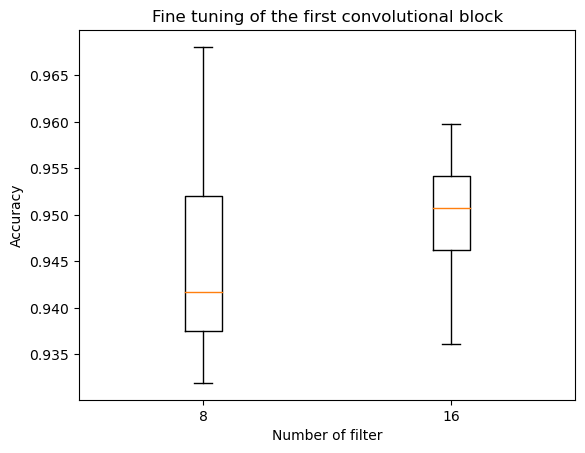

In [76]:
f, ax = plt.subplots(1)
fine_tune_plot(ax, history_conv_layer_1, 'Fine tuning of the first convolutional block', 'Number of filter', 'Accuracy') #Here we just test the number of filters, but it would be useful to test the kernel_size too

In [77]:
cnn_layers_test_2 = [ [[16, (5, 5)], [8, (5,5)]] , [[16, (5, 5)], [16, (5, 5)]]]

In [79]:
history_conv_layer_2 = {}
for i in range(len(cnn_layers_test_2)):
    print('CROSS VALIDATION with {} filters'.format(cnn_layers_test_2[i]))
    acc, y_pred = cross_val(X, Y, cnn_layers=cnn_layers_test_2[i], fc_layers=None, channel=1, epochs=10, k_fold=2)
    history_conv_layer_2[cnn_layers_test_2[i][1][0]] = acc


CROSS VALIDATION with [[16, (5, 5)], [8, (5, 5)]] filters
------------------------------
k-fold 0
Epoch 1/10
  1/225 [..............................] - ETA: 1:12 - loss: 2.2045 - accuracy: 0.1250

2022-11-23 10:53:57.779394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


225/225 [==============================] - 3s 13ms/step - loss: 1.5529 - accuracy: 0.4342
Epoch 2/10
225/225 [==============================] - 3s 12ms/step - loss: 0.8201 - accuracy: 0.7228
Epoch 3/10
225/225 [==============================] - 3s 12ms/step - loss: 0.5269 - accuracy: 0.8194
Epoch 4/10
225/225 [==============================] - 3s 12ms/step - loss: 0.3735 - accuracy: 0.8789
Epoch 5/10
225/225 [==============================] - 3s 13ms/step - loss: 0.2586 - accuracy: 0.9114
Epoch 6/10
225/225 [==============================] - 2s 11ms/step - loss: 0.1830 - accuracy: 0.9336
Epoch 7/10
225/225 [==============================] - 2s 11ms/step - loss: 0.1613 - accuracy: 0.9453
Epoch 8/10
225/225 [==============================] - 3s 11ms/step - loss: 0.1066 - accuracy: 0.9622
Epoch 9/10
225/225 [==============================] - 3s 11ms/step - loss: 0.0726 - accuracy: 0.9775
Epoch 10/10
 13/113 [==>...........................] - ETA: 0s

2022-11-23 10:54:24.915441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


113/113 [==============================] - 1s 8ms/step
Test accuracy : 0.9905555555555555
------------------------------
k-fold 1
Epoch 1/10
  1/225 [..............................] - ETA: 1:11 - loss: 2.1933 - accuracy: 0.1250

2022-11-23 10:54:26.420736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


225/225 [==============================] - 3s 11ms/step - loss: 1.4078 - accuracy: 0.4914
Epoch 2/10
225/225 [==============================] - 3s 11ms/step - loss: 0.6900 - accuracy: 0.7603
Epoch 3/10
225/225 [==============================] - 3s 11ms/step - loss: 0.4455 - accuracy: 0.8486
Epoch 4/10
225/225 [==============================] - 3s 12ms/step - loss: 0.2854 - accuracy: 0.9028
Epoch 5/10
225/225 [==============================] - 3s 12ms/step - loss: 0.2129 - accuracy: 0.9275
Epoch 6/10
225/225 [==============================] - 3s 12ms/step - loss: 0.1560 - accuracy: 0.9486
Epoch 7/10
225/225 [==============================] - 3s 12ms/step - loss: 0.1185 - accuracy: 0.9611
Epoch 8/10
225/225 [==============================] - 3s 12ms/step - loss: 0.0857 - accuracy: 0.9708
Epoch 9/10
225/225 [==============================] - 3s 12ms/step - loss: 0.0658 - accuracy: 0.9797
Epoch 10/10
 15/113 [==>...........................] - ETA: 0s

2022-11-23 10:54:53.297349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


113/113 [==============================] - 1s 5ms/step
Test accuracy : 0.8327777777777777
CROSS VALIDATION with [[16, (5, 5)], [16, (5, 5)]] filters
------------------------------
k-fold 0
Epoch 1/10


2022-11-23 10:54:55.145462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


225/225 [==============================] - 3s 12ms/step - loss: 1.4646 - accuracy: 0.4736
Epoch 2/10
225/225 [==============================] - 3s 12ms/step - loss: 0.6346 - accuracy: 0.7761
Epoch 3/10
225/225 [==============================] - 3s 11ms/step - loss: 0.3922 - accuracy: 0.8697
Epoch 4/10
225/225 [==============================] - 2s 11ms/step - loss: 0.2630 - accuracy: 0.9056
Epoch 5/10
225/225 [==============================] - 2s 11ms/step - loss: 0.1482 - accuracy: 0.9528
Epoch 6/10
225/225 [==============================] - 2s 11ms/step - loss: 0.1197 - accuracy: 0.9611
Epoch 7/10
225/225 [==============================] - 3s 12ms/step - loss: 0.0824 - accuracy: 0.9736
Epoch 8/10
225/225 [==============================] - 3s 11ms/step - loss: 0.0649 - accuracy: 0.9781
Epoch 9/10
225/225 [==============================] - 3s 11ms/step - loss: 0.0434 - accuracy: 0.9858
Epoch 10/10
 29/113 [======>.......................] - ETA: 0s

2022-11-23 10:55:21.388456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


113/113 [==============================] - 1s 5ms/step
Test accuracy : 0.9927777777777778
------------------------------
k-fold 1
Epoch 1/10
  1/225 [..............................] - ETA: 1:14 - loss: 2.1498 - accuracy: 0.0625

2022-11-23 10:55:22.545714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


225/225 [==============================] - 3s 11ms/step - loss: 1.4433 - accuracy: 0.4692
Epoch 2/10
225/225 [==============================] - 3s 11ms/step - loss: 0.6276 - accuracy: 0.7847
Epoch 3/10
225/225 [==============================] - 3s 11ms/step - loss: 0.3558 - accuracy: 0.8764
Epoch 4/10
225/225 [==============================] - 2s 11ms/step - loss: 0.1996 - accuracy: 0.9336
Epoch 5/10
225/225 [==============================] - 2s 11ms/step - loss: 0.1287 - accuracy: 0.9564
Epoch 6/10
225/225 [==============================] - 2s 11ms/step - loss: 0.0855 - accuracy: 0.9689
Epoch 7/10
225/225 [==============================] - 2s 11ms/step - loss: 0.0531 - accuracy: 0.9828
Epoch 8/10
225/225 [==============================] - 3s 12ms/step - loss: 0.0569 - accuracy: 0.9806
Epoch 9/10
225/225 [==============================] - 3s 11ms/step - loss: 0.0323 - accuracy: 0.9897
Epoch 10/10
 19/113 [====>.........................] - ETA: 0s

2022-11-23 10:55:48.281634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


113/113 [==============================] - 1s 4ms/step
Test accuracy : 0.8422222222222222


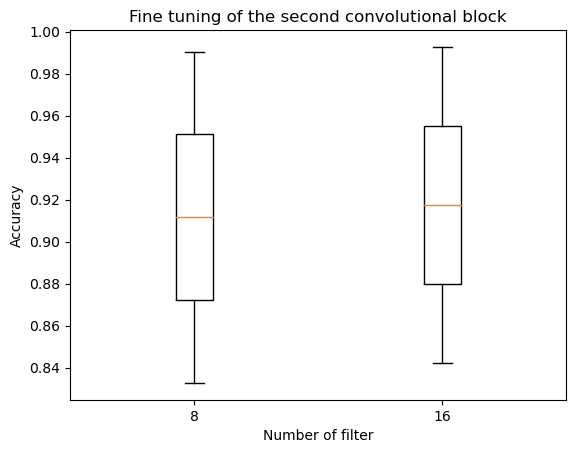

In [80]:
f, ax = plt.subplots(1)
fine_tune_plot(ax, history_conv_layer_2, 'Fine tuning of the second convolutional block', 'Number of filter', 'Accuracy') #Here we just test the number of filters, but it would be useful to test the kernel_size too

In [81]:

FC_layers_test = [32, 64, 128]
history_FC_layer = {}
for i in range(len(FC_layers_test)):
    print('CROSS VALIDATION with {} neurons in first FC layer'.format(FC_layers_test[i]))
    acc, y_pred = cross_val(X, Y, cnn_layers=cnn_layers_test_2[1], fc_layers=[FC_layers_test[i]], channel=1, epochs=10, batch_size=32, k_fold=3)
    history_FC_layer[FC_layers_test[i]] = acc

CROSS VALIDATION with 32 neurons in first FC layer
------------------------------
k-fold 0
Epoch 1/10


2022-11-23 10:58:35.854549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 2s 19ms/step - loss: 2.0193 - accuracy: 0.2313
Epoch 2/10
75/75 [==============================] - 1s 19ms/step - loss: 1.5810 - accuracy: 0.4175
Epoch 3/10
75/75 [==============================] - 1s 18ms/step - loss: 1.2522 - accuracy: 0.5296
Epoch 4/10
75/75 [==============================] - 1s 18ms/step - loss: 1.0090 - accuracy: 0.6342
Epoch 5/10
75/75 [==============================] - 1s 19ms/step - loss: 0.7925 - accuracy: 0.7121
Epoch 6/10
75/75 [==============================] - 1s 18ms/step - loss: 0.6652 - accuracy: 0.7625
Epoch 7/10
75/75 [==============================] - 1s 17ms/step - loss: 0.5348 - accuracy: 0.8058
Epoch 8/10
75/75 [==============================] - 1s 18ms/step - loss: 0.4589 - accuracy: 0.8425
Epoch 9/10
75/75 [==============================] - 1s 18ms/step - loss: 0.3860 - accuracy: 0.8700
Epoch 10/10
19/75 [======>.......................] - ETA: 0s

2022-11-23 10:58:50.319537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 0s 5ms/step
Test accuracy : 0.9891666666666666
------------------------------
k-fold 1
Epoch 1/10


2022-11-23 10:58:51.457723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - 3s 18ms/step - loss: 1.7003 - accuracy: 0.3923
Epoch 2/10
150/150 [==============================] - 3s 18ms/step - loss: 0.9935 - accuracy: 0.6523
Epoch 3/10
150/150 [==============================] - 3s 18ms/step - loss: 0.7099 - accuracy: 0.7483
Epoch 4/10
150/150 [==============================] - 3s 17ms/step - loss: 0.5317 - accuracy: 0.8156
Epoch 5/10
150/150 [==============================] - 3s 18ms/step - loss: 0.3978 - accuracy: 0.8617
Epoch 6/10
150/150 [==============================] - 3s 18ms/step - loss: 0.3049 - accuracy: 0.8913
Epoch 7/10
150/150 [==============================] - 3s 17ms/step - loss: 0.2661 - accuracy: 0.9098
Epoch 8/10
150/150 [==============================] - 3s 17ms/step - loss: 0.2227 - accuracy: 0.9258
Epoch 9/10
150/150 [==============================] - 3s 17ms/step - loss: 0.1796 - accuracy: 0.9402
Epoch 10/10
35/75 [=============>................] - ETA: 0s

2022-11-23 10:59:18.231028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 0s 5ms/step
Test accuracy : 0.9158333333333334
------------------------------
k-fold 2
Epoch 1/10
  1/150 [..............................] - ETA: 51s - loss: 2.2156 - accuracy: 0.1250

2022-11-23 10:59:19.294179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - 4s 22ms/step - loss: 1.6918 - accuracy: 0.3742
Epoch 2/10
150/150 [==============================] - 3s 17ms/step - loss: 0.9875 - accuracy: 0.6477
Epoch 3/10
150/150 [==============================] - 3s 18ms/step - loss: 0.6882 - accuracy: 0.7552
Epoch 4/10
150/150 [==============================] - 3s 17ms/step - loss: 0.4944 - accuracy: 0.8256
Epoch 5/10
150/150 [==============================] - 3s 17ms/step - loss: 0.3855 - accuracy: 0.8698
Epoch 6/10
150/150 [==============================] - 3s 17ms/step - loss: 0.3128 - accuracy: 0.8927
Epoch 7/10
150/150 [==============================] - 3s 18ms/step - loss: 0.2373 - accuracy: 0.9223
Epoch 8/10
150/150 [==============================] - 3s 17ms/step - loss: 0.2200 - accuracy: 0.9250
Epoch 9/10
150/150 [==============================] - 3s 17ms/step - loss: 0.1696 - accuracy: 0.9438
Epoch 10/10
20/75 [=======>......................] - ETA: 0s

2022-11-23 10:59:46.583874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 0s 5ms/step
Test accuracy : 0.9129166666666667
CROSS VALIDATION with 64 neurons in first FC layer
------------------------------
k-fold 0
Epoch 1/10


2022-11-23 10:59:47.982002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 2s 26ms/step - loss: 1.7398 - accuracy: 0.3804
Epoch 2/10
75/75 [==============================] - 1s 18ms/step - loss: 0.9758 - accuracy: 0.6587
Epoch 3/10
75/75 [==============================] - 1s 18ms/step - loss: 0.6459 - accuracy: 0.7800
Epoch 4/10
75/75 [==============================] - 1s 18ms/step - loss: 0.4616 - accuracy: 0.8383
Epoch 5/10
75/75 [==============================] - 1s 18ms/step - loss: 0.3218 - accuracy: 0.8992
Epoch 6/10
75/75 [==============================] - 1s 18ms/step - loss: 0.2432 - accuracy: 0.9200
Epoch 7/10
75/75 [==============================] - 1s 18ms/step - loss: 0.1894 - accuracy: 0.9417
Epoch 8/10
75/75 [==============================] - 1s 18ms/step - loss: 0.1323 - accuracy: 0.9558
Epoch 9/10
75/75 [==============================] - 1s 18ms/step - loss: 0.1314 - accuracy: 0.9563
Epoch 10/10
18/75 [======>.......................] - ETA: 0s

2022-11-23 11:00:02.625615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 0s 6ms/step
Test accuracy : 0.9979166666666667
------------------------------
k-fold 1
Epoch 1/10
  1/150 [..............................] - ETA: 52s - loss: 2.2023 - accuracy: 0.0625

2022-11-23 11:00:03.760953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - 3s 18ms/step - loss: 1.5544 - accuracy: 0.4425
Epoch 2/10
150/150 [==============================] - 3s 19ms/step - loss: 0.7287 - accuracy: 0.7456
Epoch 3/10
150/150 [==============================] - 3s 18ms/step - loss: 0.4290 - accuracy: 0.8523
Epoch 4/10
150/150 [==============================] - 3s 18ms/step - loss: 0.2805 - accuracy: 0.9017
Epoch 5/10
150/150 [==============================] - 3s 18ms/step - loss: 0.1795 - accuracy: 0.9421
Epoch 6/10
150/150 [==============================] - 3s 17ms/step - loss: 0.1319 - accuracy: 0.9575
Epoch 7/10
150/150 [==============================] - 3s 18ms/step - loss: 0.0861 - accuracy: 0.9729
Epoch 8/10
150/150 [==============================] - 3s 18ms/step - loss: 0.0779 - accuracy: 0.9731
Epoch 9/10
150/150 [==============================] - 3s 17ms/step - loss: 0.0570 - accuracy: 0.9808
Epoch 10/10
34/75 [============>.................] - ETA: 0s

2022-11-23 11:00:30.918824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 0s 5ms/step
Test accuracy : 0.9216666666666666
------------------------------
k-fold 2
Epoch 1/10
  1/150 [..............................] - ETA: 48s - loss: 2.1900 - accuracy: 0.1250

2022-11-23 11:00:31.889531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - 3s 18ms/step - loss: 1.5603 - accuracy: 0.4452
Epoch 2/10
150/150 [==============================] - 3s 17ms/step - loss: 0.7690 - accuracy: 0.7244
Epoch 3/10
150/150 [==============================] - 3s 17ms/step - loss: 0.4457 - accuracy: 0.8467
Epoch 4/10
150/150 [==============================] - 3s 17ms/step - loss: 0.3115 - accuracy: 0.8958
Epoch 5/10
150/150 [==============================] - 3s 17ms/step - loss: 0.2210 - accuracy: 0.9300
Epoch 6/10
150/150 [==============================] - 3s 17ms/step - loss: 0.1385 - accuracy: 0.9560
Epoch 7/10
150/150 [==============================] - 3s 18ms/step - loss: 0.1311 - accuracy: 0.9542
Epoch 8/10
150/150 [==============================] - 3s 18ms/step - loss: 0.1026 - accuracy: 0.9671
Epoch 9/10
150/150 [==============================] - 3s 17ms/step - loss: 0.0745 - accuracy: 0.9752
Epoch 10/10
36/75 [=============>................] - ETA: 0s

2022-11-23 11:00:58.549927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 0s 5ms/step
Test accuracy : 0.9254166666666667
CROSS VALIDATION with 128 neurons in first FC layer
------------------------------
k-fold 0
Epoch 1/10
 1/75 [..............................] - ETA: 25s - loss: 2.2198 - accuracy: 0.0625

2022-11-23 11:00:59.950917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 2s 21ms/step - loss: 1.7178 - accuracy: 0.3783
Epoch 2/10
75/75 [==============================] - 1s 18ms/step - loss: 0.8976 - accuracy: 0.6792
Epoch 3/10
75/75 [==============================] - 1s 18ms/step - loss: 0.5728 - accuracy: 0.8079
Epoch 4/10
75/75 [==============================] - 1s 18ms/step - loss: 0.3460 - accuracy: 0.8875
Epoch 5/10
75/75 [==============================] - 1s 18ms/step - loss: 0.2185 - accuracy: 0.9279
Epoch 6/10
75/75 [==============================] - 1s 18ms/step - loss: 0.1495 - accuracy: 0.9529
Epoch 7/10
75/75 [==============================] - 1s 18ms/step - loss: 0.1205 - accuracy: 0.9617
Epoch 8/10
75/75 [==============================] - 1s 18ms/step - loss: 0.0878 - accuracy: 0.9708
Epoch 9/10
75/75 [==============================] - 1s 18ms/step - loss: 0.0608 - accuracy: 0.9808
Epoch 10/10
30/75 [===========>..................] - ETA: 0s

2022-11-23 11:01:14.117904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 0s 5ms/step
Test accuracy : 0.9975
------------------------------
k-fold 1
Epoch 1/10
  1/150 [..............................] - ETA: 46s - loss: 2.1987 - accuracy: 0.1250

2022-11-23 11:01:15.055842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - 3s 18ms/step - loss: 1.4073 - accuracy: 0.5013
Epoch 2/10
150/150 [==============================] - 3s 18ms/step - loss: 0.5955 - accuracy: 0.7879
Epoch 3/10
150/150 [==============================] - 3s 18ms/step - loss: 0.3786 - accuracy: 0.8698
Epoch 4/10
150/150 [==============================] - 3s 18ms/step - loss: 0.2050 - accuracy: 0.9317
Epoch 5/10
150/150 [==============================] - 3s 18ms/step - loss: 0.1559 - accuracy: 0.9460
Epoch 6/10
150/150 [==============================] - 3s 19ms/step - loss: 0.1001 - accuracy: 0.9681
Epoch 7/10
150/150 [==============================] - 3s 19ms/step - loss: 0.0948 - accuracy: 0.9694
Epoch 8/10
150/150 [==============================] - 3s 19ms/step - loss: 0.0539 - accuracy: 0.9835
Epoch 9/10
150/150 [==============================] - 3s 18ms/step - loss: 0.0415 - accuracy: 0.9869
Epoch 10/10
17/75 [=====>........................] - ETA: 0s

2022-11-23 11:01:43.216320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 1s 6ms/step
Test accuracy : 0.9158333333333334
------------------------------
k-fold 2
Epoch 1/10
  1/150 [..............................] - ETA: 49s - loss: 2.2218 - accuracy: 0.0625

2022-11-23 11:01:45.798803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - 3s 19ms/step - loss: 1.6037 - accuracy: 0.4204
Epoch 2/10
150/150 [==============================] - 3s 18ms/step - loss: 0.8196 - accuracy: 0.7254
Epoch 3/10
150/150 [==============================] - 3s 19ms/step - loss: 0.4813 - accuracy: 0.8358
Epoch 4/10
150/150 [==============================] - 3s 19ms/step - loss: 0.2938 - accuracy: 0.9085
Epoch 5/10
150/150 [==============================] - 3s 19ms/step - loss: 0.1948 - accuracy: 0.9331
Epoch 6/10
150/150 [==============================] - 3s 18ms/step - loss: 0.1429 - accuracy: 0.9521
Epoch 7/10
150/150 [==============================] - 3s 19ms/step - loss: 0.0988 - accuracy: 0.9675
Epoch 8/10
150/150 [==============================] - 3s 18ms/step - loss: 0.0710 - accuracy: 0.9765
Epoch 9/10
150/150 [==============================] - 3s 18ms/step - loss: 0.0684 - accuracy: 0.9794
Epoch 10/10
32/75 [===========>..................] - ETA: 0s

2022-11-23 11:02:13.746084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


75/75 [==============================] - 1s 6ms/step
Test accuracy : 0.9066666666666666


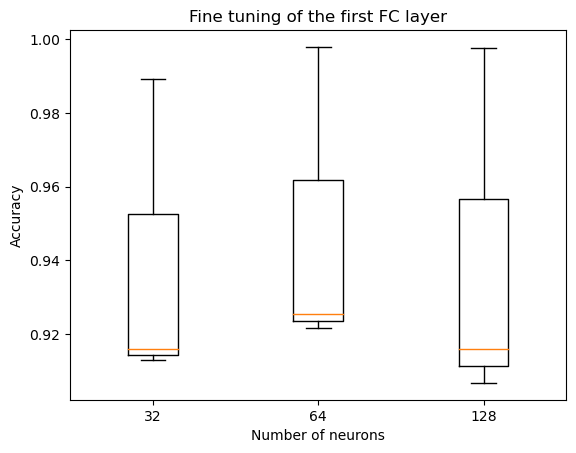

In [82]:
f, ax = plt.subplots(1)
fine_tune_plot(ax, history_FC_layer, 'Fine tuning of the first FC layer', 'Number of neurons', 'Accuracy')